In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from Unet.metrics import dice_loss, dice_coff
from Unet.rle import montage_rgb, montage, masks_as_image, rle_decode

In [36]:
BATCH_SIZE = 48
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 300

In [3]:
train_image_dir = '/kaggle/input/airbus-ship-detection/train_v2'
test_image_dir = '/kaggle/input/airbus-ship-detection/test_v2'

In [ ]:
train_df = pd.read_csv('../train_df.csv')
valid_df = pd.read_csv('../valid_df.csv')

In [53]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    
    def generator():
        while True:
            np.random.shuffle(all_batches)
            for c_img_id, c_masks in all_batches:
                rgb_path = os.path.join(train_image_dir, c_img_id)
                c_img = imread(rgb_path)
                c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
                
                if IMG_SCALING is not None:
                    c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                    c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
                
                yield c_img/255.0, c_mask

    dataset = tf.data.Dataset.from_generator(generator,
                                             output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
                                                               tf.TensorSpec(shape=(None, None, 1), dtype=tf.uint8)))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [54]:
train_ds = make_image_gen(train_df, 32)

x, y = next(train_ds.as_numpy_iterator())

x.shape, y.shape

((32, 256, 256, 3), (32, 256, 256, 1))

In [72]:
valid_ds = make_image_gen(valid_df, VALID_IMG_COUNT).as_numpy_iterator()
valid_x, valid_y = next(valid_ds)
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


In [73]:
input_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.25, seed=42),  # Rotation range is -45 to 45 degrees
    tf.keras.layers.RandomWidth(factor=0.1, seed=42),  # Width shift range is -10% to 10%
    tf.keras.layers.RandomHeight(factor=0.1, seed=42),  # Height shift range is -10% to 10%
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.25), width_factor=(-0.1, 0.25), seed=42),  # Zoom range is 0.9 to 1.25
    tf.keras.layers.RandomFlip("horizontal", seed=42),  # Horizontal flip
    tf.keras.layers.RandomFlip("vertical", seed=42),
    tf.keras.layers.Resizing(256, 256)
])
output_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.25, seed=42),  # Rotation range is -45 to 45 degrees
    tf.keras.layers.RandomWidth(factor=0.1, seed=42),  # Width shift range is -10% to 10%
    tf.keras.layers.RandomHeight(factor=0.1, seed=42),  # Height shift range is -10% to 10%
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.25), width_factor=(-0.1, 0.25), seed=42),  # Zoom range is 0.9 to 1.25
    tf.keras.layers.RandomFlip("horizontal", seed=42),  # Horizontal flip
    tf.keras.layers.RandomFlip("vertical", seed=42),
    tf.keras.layers.Resizing(256, 256)
])

In [74]:
def augmentation(input_img, output_img):
    return input_augmentation(input_img), output_augmentation(output_img)

augmented_ds = train_ds.map(augmentation)

In [87]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
def create_unet(filters=8,
                img_size=(256, 256, 3),
                dropout_rate=0.1,
                kernel_size=(3, 3),
                pool_size=(2, 2),
                strides=(2, 2)):

    inputs = Input(img_size)
    
    # Contraction path
    c1 = Conv2D(filters, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(filters, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D(pool_size)(c1)

    c2 = Conv2D(filters * 2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(filters * 2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D(pool_size)(c2)

    c3 = Conv2D(filters * 4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(filters * 4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D(pool_size)(c3)

    c4 = Conv2D(filters * 8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(filters * 8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size)(c4)

    # Bridge (1024)
    c5 = Conv2D(filters * 16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(filters * 16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(filters * 8, pool_size, strides=strides, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters * 8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(filters * 8, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(filters * 4, pool_size, strides=strides, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters * 4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(filters * 4, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(filters * 2, pool_size, strides=strides, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters * 2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(dropout_rate)(c8)
    c8 = Conv2D(filters * 2, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(filters, pool_size, strides=strides, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(filters, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(dropout_rate)(c9)
    c9 = Conv2D(filters, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c9)

    model = Model(inputs=[inputs], outputs=[outputs], name='unet')
    print(model.summary())

    return model

model = create_unet()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 256, 256, 8)          224       ['input_10[0][0]']            
                                                                                                  
 dropout_81 (Dropout)        (None, 256, 256, 8)          0         ['conv2d_171[0][0]']          
                                                                                                  
 conv2d_172 (Conv2D)         (None, 256, 256, 8)          584       ['dropout_81[0][0]']          
                                                                                               

In [90]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True, verbose=1)

In [91]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=[dice_coff])

In [21]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [92]:
history = model.fit(train_ds, epochs=100, verbose=1, callbacks=[early_stopping], 
                    steps_per_epoch=min(MAX_TRAIN_STEPS, len(train_df)//BATCH_SIZE), validation_data=[valid_x, valid_y])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-02 18:01:41.123027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inunet/dropout_81/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 128s 401ms/step - loss: 0.0297 - dice_coff: 0.0540 - val_loss: 0.0050 - val_dice_coff: 0.1427
Epoch 2/100
300/300 [==============================] - 110s 369ms/step - loss: 0.0049 - dice_coff: 0.2126 - val_loss: 0.0039 - val_dice_coff: 0.2518
Epoch 3/100
300/300 [==============================] - 111s 370ms/step - loss: 0.0040 - dice_coff: 0.2768 - val_loss: 0.0034 - val_dice_coff: 0.3138
Epoch 4/100
300/300 [==============================] - 110s 366ms/step - loss: 0.0036 - dice_coff: 0.3080 - val_loss: 0.0032 - val_dice_coff: 0.3347
Epoch 5/100
300/300 [==============================] - 121s 404ms/step - loss: 0.0034 - dice_coff: 0.3341 - val_loss: 0.0029 - val_dice_coff: 0.4003
Epoch 6/100
300/300 [==============================] - 126s 420ms/step - loss: 0.0032 - dice_coff: 0.3626 - val_loss: 0.0035 - val_dice_coff: 0.3279
Epoch 7/100
300/300 [==============================] - 110s 368ms/step - loss: 0.0030 - dice_coff: 0.3904 - val_loss: 

In [98]:
predicted = model.predict(valid_x)

29/29 [==============================] - 1s 37ms/step


In [97]:
model.save('/kaggle/working/model.keras')

In [99]:
predictions = np.where(predicted > 0.5, 1, 0)
predictions.shape

(900, 256, 256, 1)

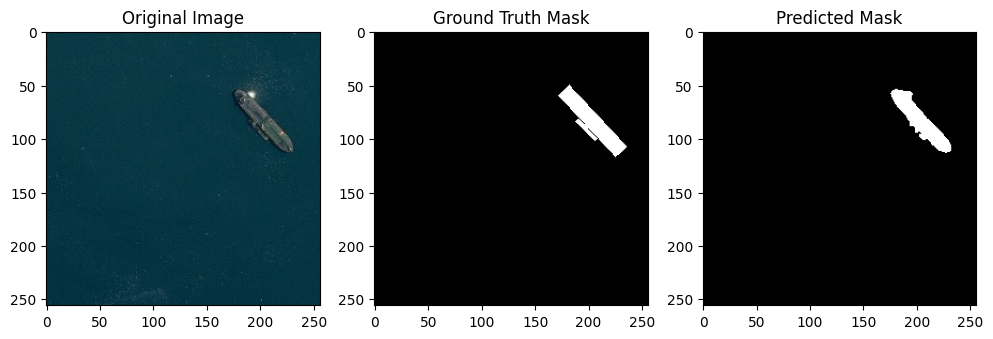

In [101]:
plt.figure(figsize=(12, 10))
# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(valid_x[0])
plt.title('Original Image')

# Display the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(valid_y[0]), cmap='gray')
plt.title('Ground Truth Mask')

# Display the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predictions[0]), cmap='gray')
plt.title('Predicted Mask')
    

plt.show()